In [1]:
import pandas as pd
import numpy as np
import ast
import pickle
from pathlib import Path
import multirecording_spikeanalysis as spike

cols = ['condition ', 'session_dir', 'all_subjects', 'tone_start_timestamp', 'tone_stop_timestamp']

# Load the data
df = pd.read_excel('rce_pilot_2_per_video_trial_labels.xlsx', usecols=cols, engine='openpyxl')

df2 = df.dropna() # Drop the rows missing data
df3 = df2.copy()
df3['all_subjects'] = df3['all_subjects'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x) # Make the 'all_subjects' column readable as a list
df4 = df3[df3['all_subjects'].apply(lambda x: len(x) < 3)] # Ignore novel sessions for now

# Initialize an empty list to collect data for the new DataFrame
new_df_data = []

for _, row in df4.iterrows():
    session_dir = row['session_dir']
    subjects = row['all_subjects']
    condition = row['condition ']

    # Split session_dir on '_subj_' and take the first part only
    # This ensures everything after '_subj_' is ignored
    base_session_dir = session_dir.split('_subj_')[0]

    for subject in subjects:
        subject_formatted = subject.replace('.', '-')
        # Append formatted subject to the base session_dir correctly
        subj_recording = f"{base_session_dir}_subj_{subject_formatted}"
        new_df_data.append({
            'session_dir': session_dir,
            'subject': subject,
            'subj_recording': subj_recording,
            'condition': condition if condition in ['rewarded', 'omission', 'both_rewarded', 'tie'] else ('win' if str(condition) == str(subject) else 'lose'),
            'tone_start_timestamp': row['tone_start_timestamp'],
            'tone_stop_timestamp': row['tone_stop_timestamp']
        })

# Convert list to DataFrame
new_df = pd.DataFrame(new_df_data)
new_df = new_df.drop_duplicates()

# Prepare timestamp_dicts from new_df
timestamp_dicts = {}
for _, row in new_df.iterrows():
    key = row['subj_recording']
    condition = row['condition']
    timestamp_start = int(row['tone_start_timestamp']) // 20
    timestamp_end = int(row['tone_stop_timestamp']) // 20
    tuple_val = (timestamp_start, timestamp_end)

    if key not in timestamp_dicts:
        timestamp_dicts[key] = {cond: [] for cond in ['rewarded', 'win', 'lose', 'omission', 'both_rewarded', 'tie']}
    timestamp_dicts[key][condition].append(tuple_val)

# Convert lists in timestamp_dicts to numpy arrays
for subj_recording in timestamp_dicts:
    for condition in timestamp_dicts[subj_recording]:
        timestamp_dicts[subj_recording][condition] = np.array(timestamp_dicts[subj_recording][condition], dtype=np.int64)

# Construct the path in a platform-independent way (HiPerGator or Windows)
ephys_path = Path('.') / 'export' / 'updated_phys' / 'non-novel' / 'both_rewarded'

ephys_data = spike.EphysRecordingCollection(str(ephys_path))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Unit 92 is unsorted & has 2494 spikes
Unit 92 will be deleted
20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1_t1b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Unit 103 is unsorted & has 512 spikes
Unit 103 will be deleted
20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-2_t3b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230624_105855_standard_comp_to_both_rewarded_D3_subj_1-2_t1b2L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230624_105855_standard_comp_to_both_rewarded_D3_subj_1-4_t3b3L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
20230625_112913_standard_comp_to_both_rewarded_D4_subj_1-1_t1b2L_box1_merged.rec
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Unit 96 is unsorted & has 5811 spikes
Unit 96 will be deleted
Unit 95 is unsorted & has 6458 spikes
Unit 95 will be deleted
20230625_112913_standard_comp_to_both_rewarded_D4_subj_1-4

In [2]:
for recording in ephys_data.collection.keys():
    # Check if the recording key (without everything after subject #) is in timestamp_dicts
    start_pos = recording.find('subj_')
    # Add the length of 'subj_' and 3 additional characters to include after 'subj_'
    end_pos = start_pos + len('subj_') + 3
    # Slice the recording key to get everything up to and including the subject identifier plus three characters
    recording_key_without_suffix = recording[:end_pos]
    if recording_key_without_suffix in timestamp_dicts:
        # Assign the corresponding timestamp_dicts dictionary to event_dict
        ephys_data.collection[recording].event_dict = timestamp_dicts[recording_key_without_suffix]
        
        # Extract the subject from the recording key
        start = recording.find('subj_') + 5  # Start index after 'subj_'
        subject = recording[start:start+3]
        
        # Assign the extracted subject
        ephys_data.collection[recording].subject = subject

In [19]:
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin = 100, smoothing_window=250, ignore_freq = 0.5)

All set to analyze


In [20]:
# Create df of spike freq 10s before and 10s during every event
event_spikes = spike_analysis.generate_event_dataframe()

# Identify 'Pre-event' and 'Event' columns
pre_event_cols = [col for col in event_spikes.columns if col.startswith('Pre-event')]
event_cols = [col for col in event_spikes.columns if col.startswith('Event') and col not in ['Event name', 'Event number']]

In [21]:
event_spikes

Recording     Event name  \
0     20230622_110832_standard_comp_to_both_rewarded...           lose   
1     20230622_110832_standard_comp_to_both_rewarded...           lose   
2     20230622_110832_standard_comp_to_both_rewarded...           lose   
3     20230622_110832_standard_comp_to_both_rewarded...           lose   
4     20230622_110832_standard_comp_to_both_rewarded...           lose   
...                                                 ...            ...   
4796  20230625_112913_standard_comp_to_both_rewarded...  both_rewarded   
4797  20230625_112913_standard_comp_to_both_rewarded...  both_rewarded   
4798  20230625_112913_standard_comp_to_both_rewarded...  both_rewarded   
4799  20230625_112913_standard_comp_to_both_rewarded...  both_rewarded   
4800  20230625_112913_standard_comp_to_both_rewarded...  both_rewarded   

      Event number  Unit number  Pre-event timebin 1  Pre-event timebin 2  \
0                1            9                  5.0                 15.0   
1                2            9                  5.0                  5.0   
2                3            9                 10.0                  5.0   
3                4            9                 10.0                  5.0   
4                5            9                  5.0                 20.0   
...            ...          ...                  ...                  ...   
4796            16           11                  0.0                  0.0   
4797            17           11                  0.0                  0.0   
4798            18           11                  0.0                  0.0   
4799            19           11                  0.0                  0.0   
4800            20           11                  0.0                  0.0   

      Pre-event timebin 3  Pre-event timebin 4  Pre-event timebin 5  \
0                    10.0                  5.0                  5.0   
1                    10.0                 20.0                 20.0   
2                    15.0                 25.0                 25.0   
3                     5.0                  5.0                 10.0   
4                    25.0                 20.0                 25.0   
...                   ...                  ...                  ...   
4796                  0.0                  0.0                  0.0   
4797                  0.0                  0.0                  0.0   
4798                  0.0                  0.0                  0.0   
4799                  0.0                  0.0                  0.0   
4800                  0.0                  0.0                  0.0   

      Pre-event timebin 6  ...  Event timebin 91  Event timebin 92  \
0                     5.0  ...              15.0              15.0   
1                    20.0  ...               5.0              10.0   
2                    20.0  ...              25.0              25.0   
3                    20.0  ...               5.0              10.0   
4                    45.0  ...               5.0              10.0   
...                   ...  ...               ...               ...   
4796                  0.0  ...               0.0               0.0   
4797                  0.0  ...               0.0               0.0   
4798                  0.0  ...               0.0               0.0   
4799                  0.0  ...               0.0               0.0   
4800                  0.0  ...               5.0               5.0   

      Event timebin 93  Event timebin 94  Event timebin 95  Event timebin 96  \
0                 10.0               0.0               5.0              10.0   
1                 20.0              25.0              10.0               5.0   
2                 10.0               5.0               0.0              15.0   
3                 10.0              10.0              10.0              15.0   
4                 20.0              15.0              10.0              15.0   
...                ...               ...               ...

In [41]:
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin = 100, smoothing_window=500, ignore_freq = 0.5)

All set to analyze


In [42]:
recordings = spike_analysis.ephyscollection.collection
recording_name = '20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1_t1b3L_box1_merged.rec'
recording1 = recordings.get(recording_name)

recording1.unit_spiketrains

{9: array([1, 1, 0, ..., 0, 0, 0], dtype=int64),
 24: array([0, 1, 0, ..., 0, 0, 0], dtype=int64),
 76: array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 10: array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 94: array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 87: array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 1: array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 15: array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 97: array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 39: array([0, 0, 0, ..., 0, 1, 0], dtype=int64),
 2: array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 11: array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 77: array([0, 0, 0, ..., 0, 0, 0], dtype=int64)}

In [43]:
len(recording1.unit_spiketrains[9])

33673

In [44]:
len(recording1.unit_firing_rates[9])

33673

In [47]:
recording1.unit_timestamps[9][:20]

[205,
 3771,
 12725,
 13046,
 17630,
 35690,
 39470,
 40105,
 41307,
 42689,
 43084,
 44131,
 46264,
 46552,
 48892,
 49493,
 50583,
 51194,
 51556,
 53428]

In [51]:
print("unit 9 timestamp length: ", len(recording1.unit_timestamps[9]))
print("unit 24 timestamp length: ", len(recording1.unit_timestamps[24]))

unit 9 timestamp length:  49495
unit 24 timestamp length:  1733


In [52]:
recording1.freq_dict

{9: 14.698354690022406,
 24: 0.5146428665079065,
 76: 1.3134826304468956,
 10: 1.5412559014287561,
 94: 2.1227162203107417,
 87: 1.318828026636822,
 1: 1.7690291724106166,
 15: 1.5281893774089363,
 97: 0.8591239543031582,
 39: 0.6165023605715024,
 2: 1.5154198198441122,
 11: 1.506807792649231,
 77: 0.6224416896714206}

In [69]:
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin = 1000, smoothing_window=1000, ignore_freq = 0.5)

All set to analyze


In [70]:
recordings = spike_analysis.ephyscollection.collection
recording_name = '20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1_t1b3L_box1_merged.rec'
recording1 = recordings.get(recording_name)

len(recording1.unit_spiketrains[9])

3367

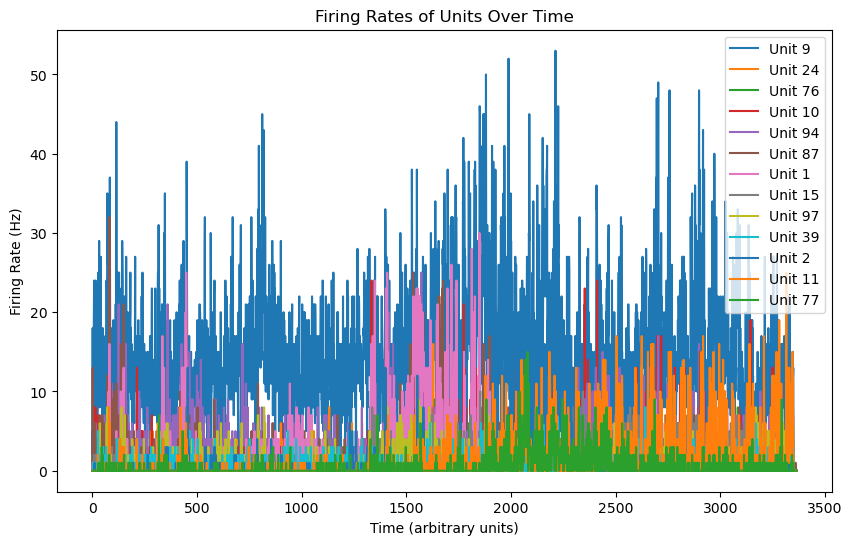

In [73]:
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(10, 6))
time = np.arange(len(next(iter(recording1.unit_firing_rates.values()))))  # Assuming all arrays are the same length

for unit, rates in recording1.unit_firing_rates.items():
    plt.plot(time, rates, label=f'Unit {unit}')

plt.xlabel('Time (arbitrary units)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Firing Rates of Units Over Time')
plt.legend()
plt.show()

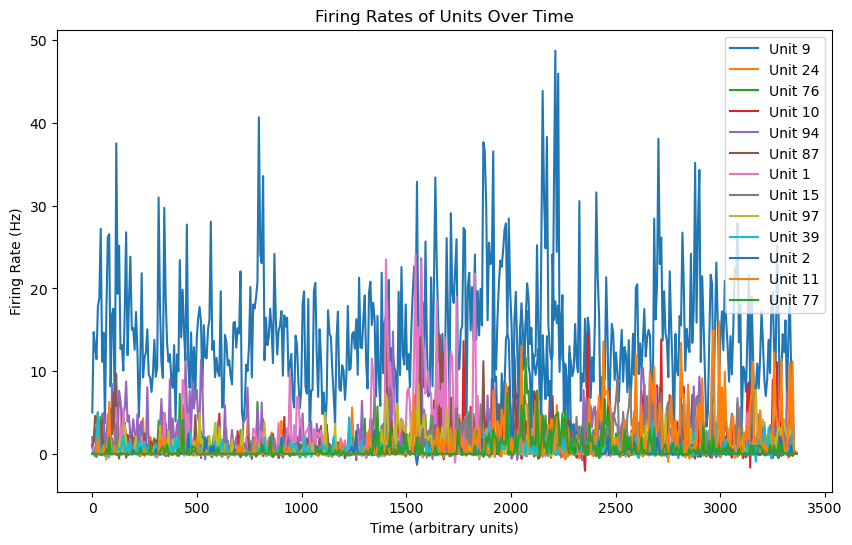

In [74]:
from scipy.interpolate import interp1d

plt.figure(figsize=(10, 6))
time = np.arange(len(next(iter(recording1.unit_firing_rates.values()))))  # Original time points

# Loop through each unit
for unit, rates in recording1.unit_firing_rates.items():
    # Create interpolation function based on the original data points
    interp_func = interp1d(time, rates, kind='cubic')
    
    # Generate new finer time points for a smoother curve
    time_fine = np.linspace(time.min(), time.max(), num=500)
    rates_smooth = interp_func(time_fine)  # Apply interpolation function to the finer time points
    
    plt.plot(time_fine, rates_smooth, label=f'Unit {unit}')  # Plot the smoothed data

plt.xlabel('Time (arbitrary units)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Firing Rates of Units Over Time')
plt.legend()
plt.show()

In [75]:
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin = 100, smoothing_window=250, ignore_freq = 0.5)

All set to analyze


In [76]:
recordings = spike_analysis.ephyscollection.collection
recording_name = '20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1_t1b3L_box1_merged.rec'
recording1 = recordings.get(recording_name)

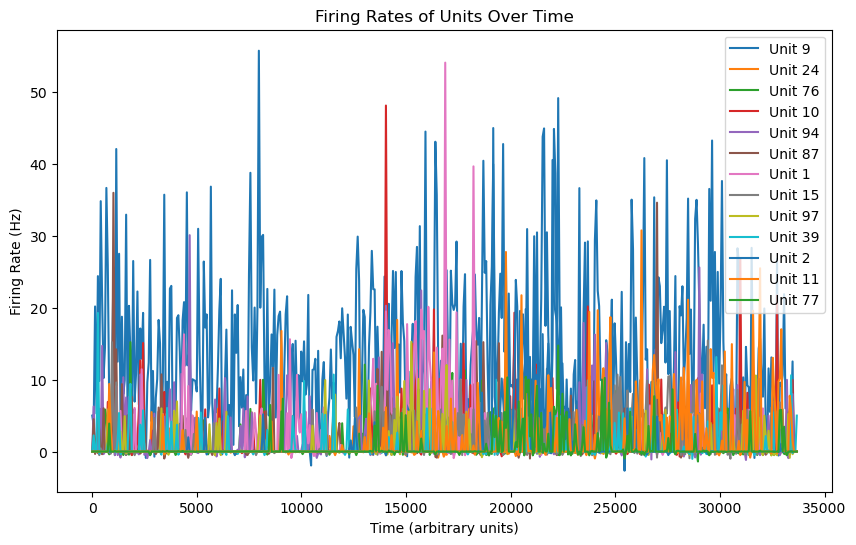

In [77]:
plt.figure(figsize=(10, 6))
time = np.arange(len(next(iter(recording1.unit_firing_rates.values()))))  # Original time points

# Loop through each unit
for unit, rates in recording1.unit_firing_rates.items():
    # Create interpolation function based on the original data points
    interp_func = interp1d(time, rates, kind='cubic')
    
    # Generate new finer time points for a smoother curve
    time_fine = np.linspace(time.min(), time.max(), num=500)
    rates_smooth = interp_func(time_fine)  # Apply interpolation function to the finer time points
    
    plt.plot(time_fine, rates_smooth, label=f'Unit {unit}')  # Plot the smoothed data

plt.xlabel('Time (arbitrary units)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Firing Rates of Units Over Time')
plt.legend()
plt.show()

In [78]:
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin = 200, smoothing_window=600, ignore_freq = 0.5)

All set to analyze


In [79]:
recordings = spike_analysis.ephyscollection.collection
recording_name = '20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1_t1b3L_box1_merged.rec'
recording1 = recordings.get(recording_name)

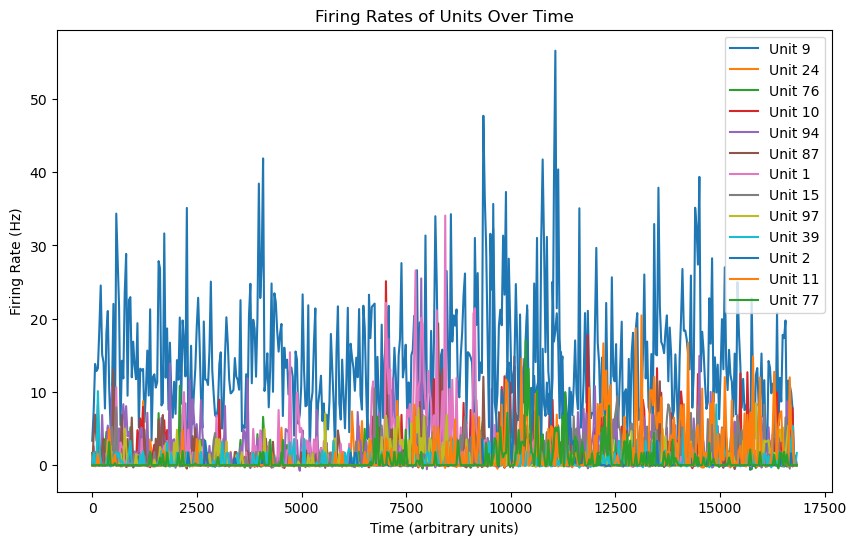

In [80]:
plt.figure(figsize=(10, 6))
time = np.arange(len(next(iter(recording1.unit_firing_rates.values()))))  # Original time points

# Loop through each unit
for unit, rates in recording1.unit_firing_rates.items():
    # Create interpolation function based on the original data points
    interp_func = interp1d(time, rates, kind='cubic')
    
    # Generate new finer time points for a smoother curve
    time_fine = np.linspace(time.min(), time.max(), num=500)
    rates_smooth = interp_func(time_fine)  # Apply interpolation function to the finer time points
    
    plt.plot(time_fine, rates_smooth, label=f'Unit {unit}')  # Plot the smoothed data

plt.xlabel('Time (arbitrary units)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Firing Rates of Units Over Time')
plt.legend()
plt.show()

In [81]:
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin = 100, smoothing_window=250, ignore_freq = 0.5)

All set to analyze


In [82]:
recordings = spike_analysis.ephyscollection.collection
recording_name = '20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1_t1b3L_box1_merged.rec'
recording1 = recordings.get(recording_name)

In [83]:
for unit, rates in recording1.unit_firing_rates.items():
    mean_rate = np.mean(rates)
    std_rate = np.std(rates)
    print(f"Unit {unit} - Mean Firing Rate: {mean_rate:.2f}, Std Dev: {std_rate:.2f}")

Unit 9 - Mean Firing Rate: 14.70, Std Dev: 11.25
Unit 24 - Mean Firing Rate: 0.51, Std Dev: 1.86
Unit 76 - Mean Firing Rate: 1.31, Std Dev: 2.67
Unit 10 - Mean Firing Rate: 1.54, Std Dev: 3.76
Unit 94 - Mean Firing Rate: 2.12, Std Dev: 4.50
Unit 87 - Mean Firing Rate: 1.32, Std Dev: 3.91
Unit 1 - Mean Firing Rate: 1.77, Std Dev: 4.31
Unit 15 - Mean Firing Rate: 1.53, Std Dev: 2.98
Unit 97 - Mean Firing Rate: 0.86, Std Dev: 2.22
Unit 39 - Mean Firing Rate: 0.62, Std Dev: 1.92
Unit 2 - Mean Firing Rate: 1.52, Std Dev: 4.68
Unit 11 - Mean Firing Rate: 1.51, Std Dev: 3.90
Unit 77 - Mean Firing Rate: 0.62, Std Dev: 2.11


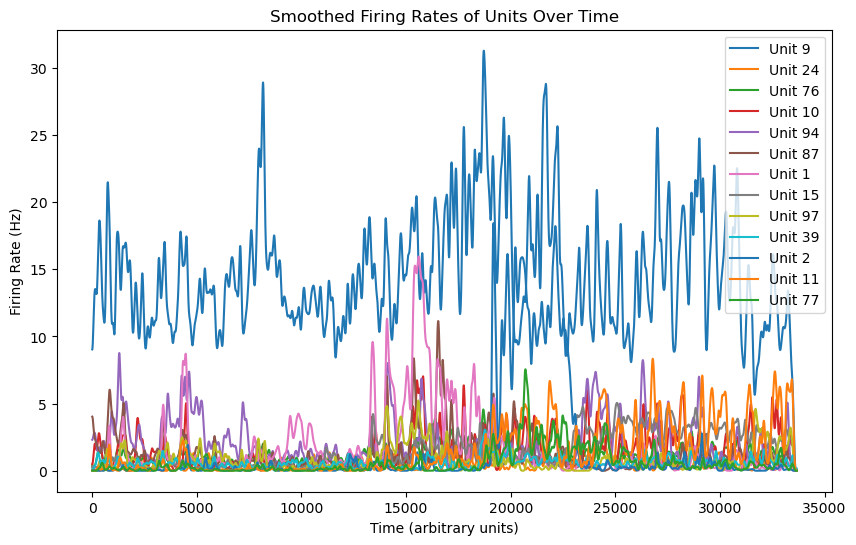

In [85]:
from scipy.ndimage import gaussian_filter

plt.figure(figsize=(10, 6))

# Smoothing the data with a Gaussian filter
for unit, rates in recording1.unit_firing_rates.items():
    smoothed_rates = gaussian_filter(rates, sigma=50)  # Adjust sigma as needed for smoother results
    plt.plot(smoothed_rates, label=f'Unit {unit}')

plt.xlabel('Time (arbitrary units)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Smoothed Firing Rates of Units Over Time')
plt.legend()
plt.show()

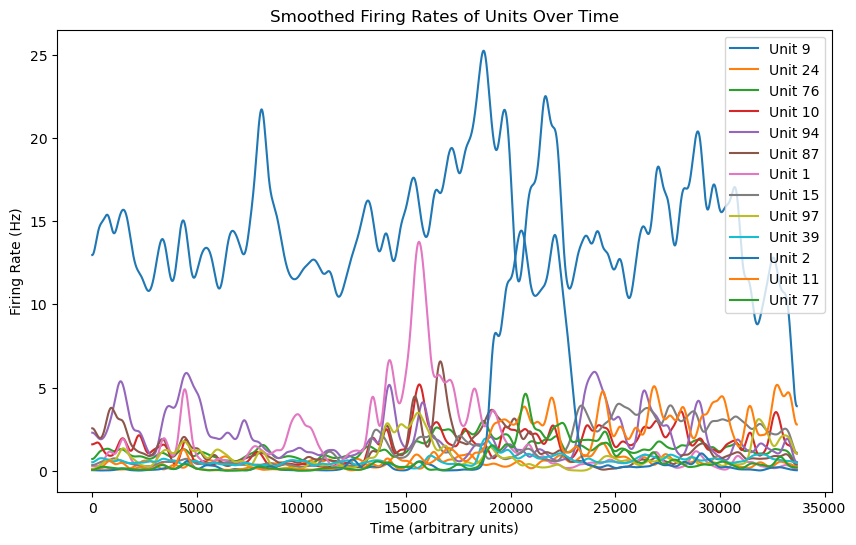

In [86]:
plt.figure(figsize=(10, 6))

# Smoothing the data with a Gaussian filter
for unit, rates in recording1.unit_firing_rates.items():
    smoothed_rates = gaussian_filter(rates, sigma=200)  # Adjust sigma as needed for smoother results
    plt.plot(smoothed_rates, label=f'Unit {unit}')

plt.xlabel('Time (arbitrary units)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Smoothed Firing Rates of Units Over Time')
plt.legend()
plt.show()

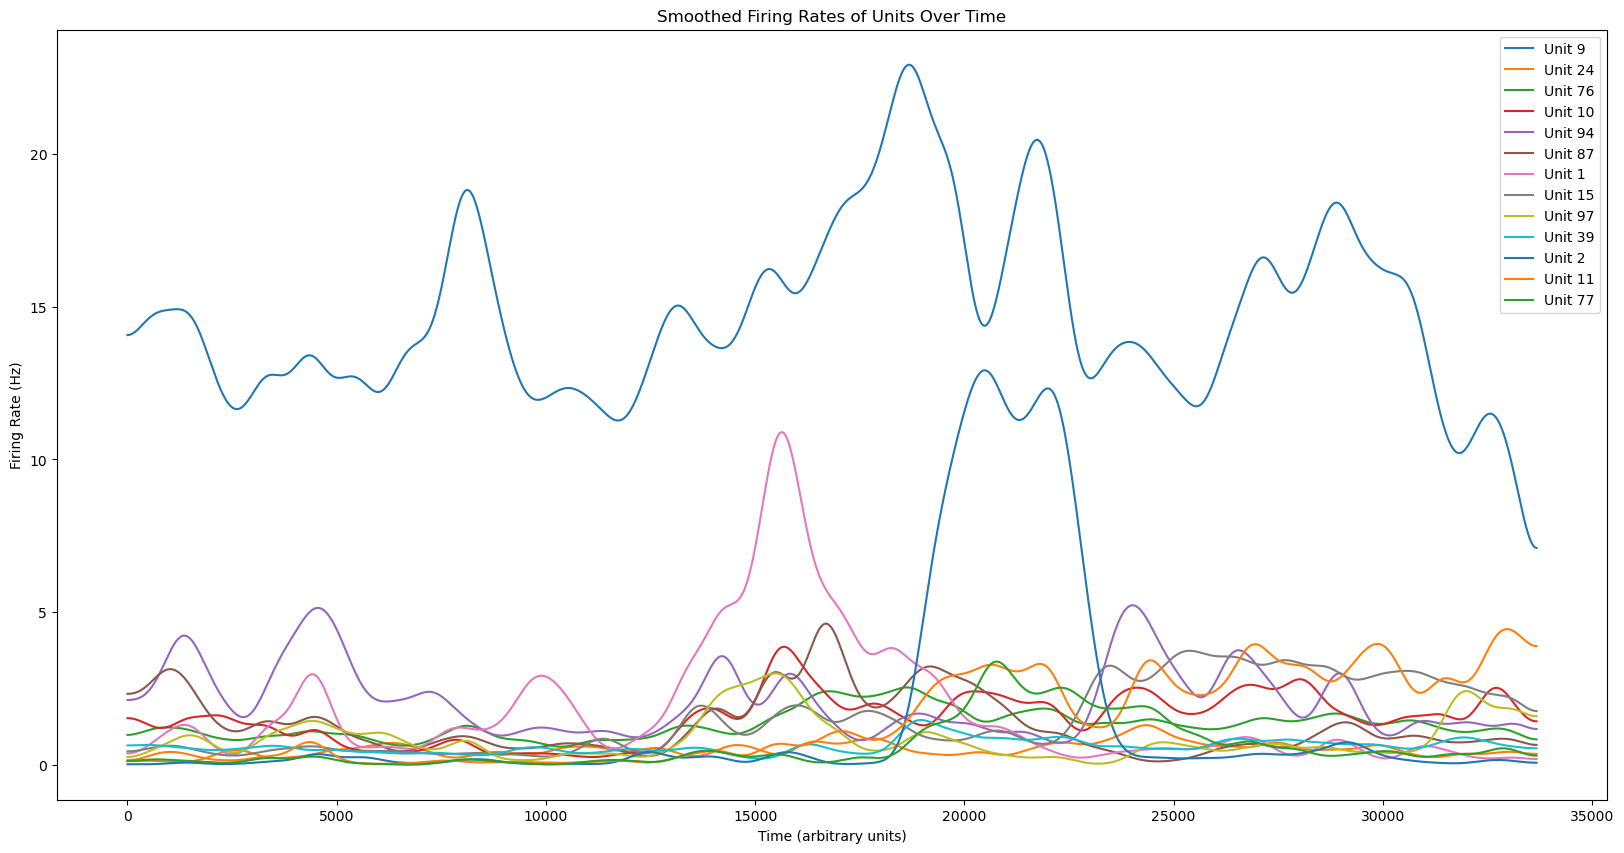

In [88]:
plt.figure(figsize=(20, 10))

# Smoothing the data with a Gaussian filter
for unit, rates in recording1.unit_firing_rates.items():
    smoothed_rates = gaussian_filter(rates, sigma=400)  # Adjust sigma as needed for smoother results
    plt.plot(smoothed_rates, label=f'Unit {unit}')

plt.xlabel('Time (arbitrary units)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Smoothed Firing Rates of Units Over Time')
plt.legend()
plt.show()

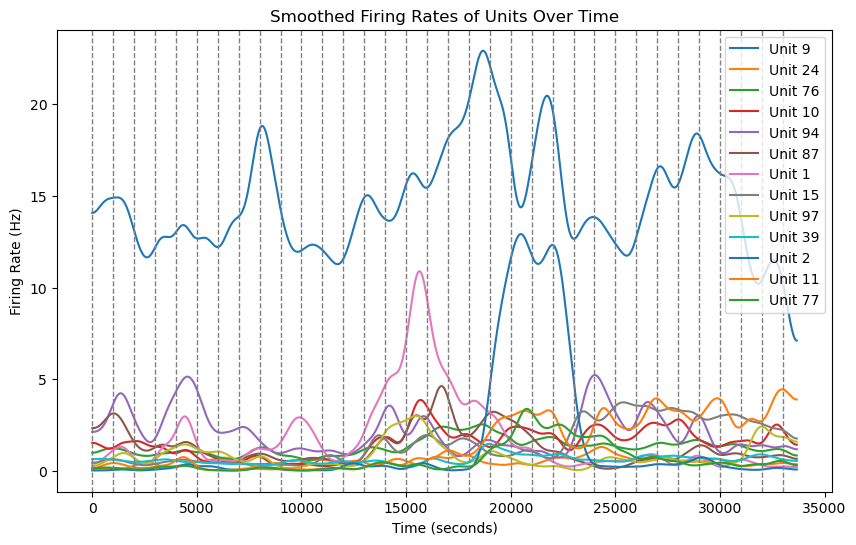

In [90]:
plt.figure(figsize=(10, 6))

# Determine the indices for vertical lines every 10 seconds
# Since each bin is 100ms, 10 seconds would be every 100 bins
ten_second_intervals = np.arange(0, len(next(iter(recording1.unit_firing_rates.values()))), 1000)

# Plotting each unit's firing rate
for unit, rates in recording1.unit_firing_rates.items():
    smoothed_rates = gaussian_filter(rates, sigma=400)  # Adjust sigma for desired smoothness
    plt.plot(smoothed_rates, label=f'Unit {unit}')

# Adding vertical dashed lines every 10 seconds
for idx in ten_second_intervals:
    plt.axvline(x=idx, color='gray', linestyle='--', linewidth=1)

plt.xlabel('Time (seconds)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Smoothed Firing Rates of Units Over Time')
plt.legend()
plt.show()

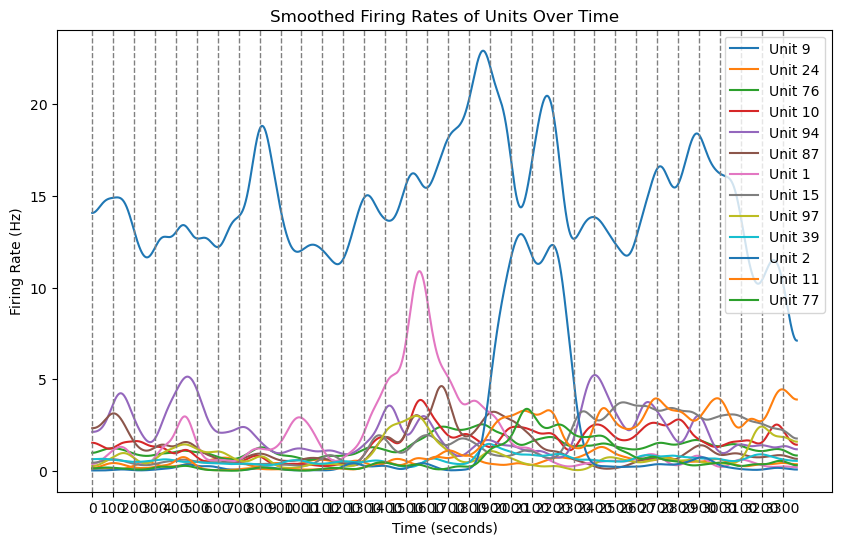

In [91]:
plt.figure(figsize=(10, 6))

# Plotting each unit's firing rate
for unit, rates in recording1.unit_firing_rates.items():
    smoothed_rates = gaussian_filter(rates, sigma=400)  # Adjust sigma for desired smoothness
    plt.plot(smoothed_rates, label=f'Unit {unit}')

# Adjust the x-axis to display time in seconds
total_bins = len(next(iter(recording1.unit_firing_rates.values())))
time_seconds = np.arange(total_bins) / 10  # Convert bin index to seconds (10 bins per second)
plt.xticks(np.arange(0, total_bins, 1000), labels=[f"{int(x/10)}" for x in np.arange(0, total_bins, 1000)])  # Update labels every 10 seconds

# Adding vertical dashed lines every 10 seconds
ten_second_intervals = np.arange(0, total_bins, 1000)
for idx in ten_second_intervals:
    plt.axvline(x=idx, color='gray', linestyle='--', linewidth=1)

plt.xlabel('Time (seconds)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Smoothed Firing Rates of Units Over Time')
plt.legend()
plt.show()

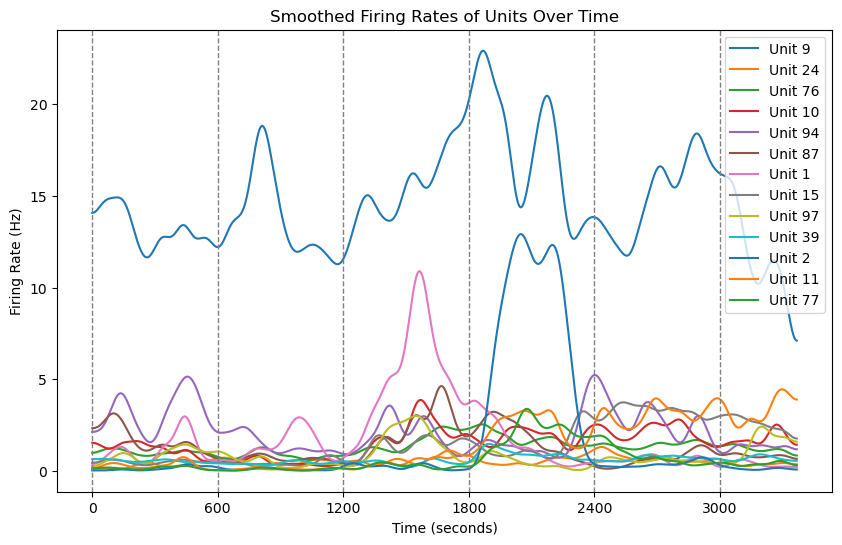

In [92]:
plt.figure(figsize=(10, 6))

# Plotting each unit's firing rate
for unit, rates in recording1.unit_firing_rates.items():
    smoothed_rates = gaussian_filter(rates, sigma=400)  # Adjust sigma for desired smoothness
    plt.plot(smoothed_rates, label=f'Unit {unit}')

# Adjust the x-axis to display time in seconds
total_bins = len(next(iter(recording1.unit_firing_rates.values())))
plt.xticks(np.arange(0, total_bins, 6000), labels=[f"{int(x/10)}" for x in np.arange(0, total_bins, 6000)])  # Update labels every 60 seconds

# Adding vertical dashed lines every 60 seconds
sixty_second_intervals = np.arange(0, total_bins, 6000)
for idx in sixty_second_intervals:
    plt.axvline(x=idx, color='gray', linestyle='--', linewidth=1)

plt.xlabel('Time (seconds)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Smoothed Firing Rates of Units Over Time')
plt.legend()
plt.show()

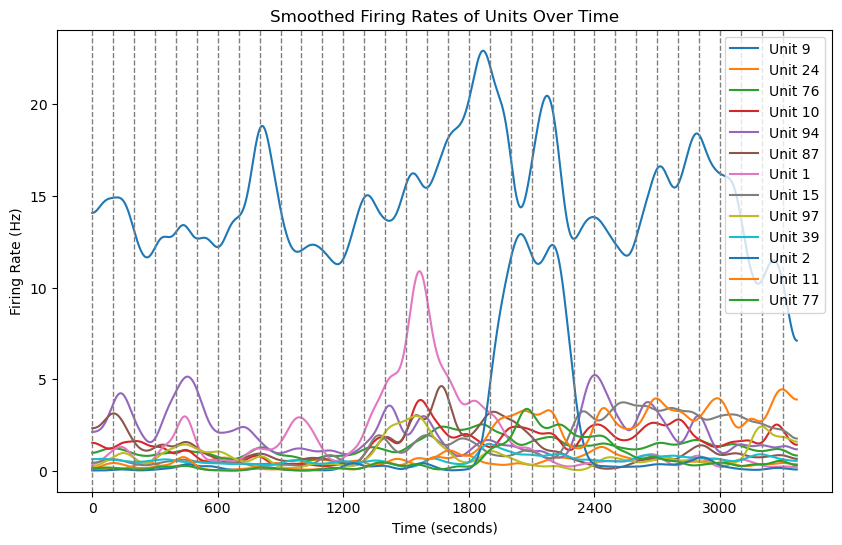

In [94]:
plt.figure(figsize=(10, 6))

# Plotting each unit's firing rate
for unit, rates in recording1.unit_firing_rates.items():
    smoothed_rates = gaussian_filter(rates, sigma=400)  # Adjust sigma for desired smoothness
    plt.plot(smoothed_rates, label=f'Unit {unit}')

# Adjust the x-axis to display time in seconds
total_bins = len(next(iter(recording1.unit_firing_rates.values())))
plt.xticks(np.arange(0, total_bins, 6000), labels=[f"{int(x/10)}" for x in np.arange(0, total_bins, 6000)])  # Update labels every 60 seconds

# Adding vertical dashed lines every 10 seconds
ten_second_intervals = np.arange(0, total_bins, 1000)
for idx in ten_second_intervals:
    plt.axvline(x=idx, color='gray', linestyle='--', linewidth=1)

plt.xlabel('Time (seconds)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Smoothed Firing Rates of Units Over Time')
plt.legend()
plt.show()

In [95]:
recordings = spike_analysis.ephyscollection.collection
recording_name = '20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1_t1b3L_box1_merged.rec'
recording1 = recordings.get(recording_name)

len(recording1.unit_spiketrains[9])

33673

In [96]:
33573*100/1000/60

55.955000000000005

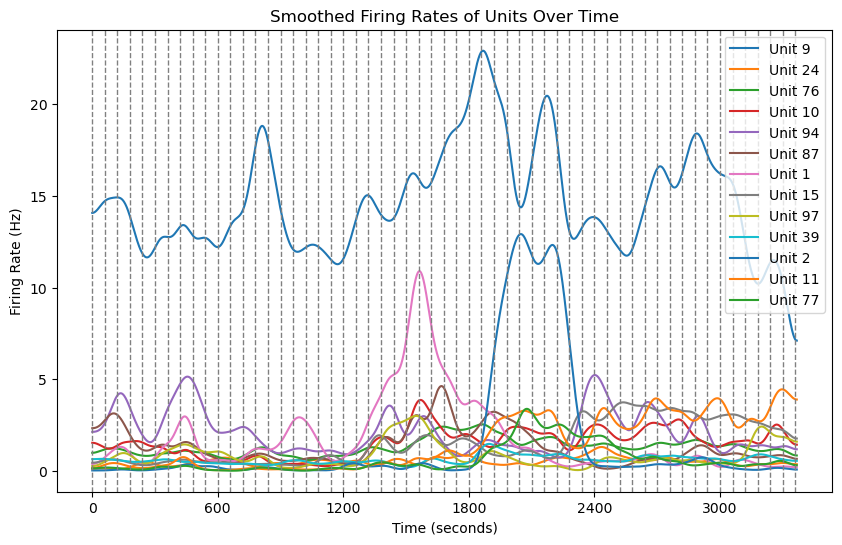

In [97]:
plt.figure(figsize=(10, 6))

# Plotting each unit's firing rate
for unit, rates in recording1.unit_firing_rates.items():
    smoothed_rates = gaussian_filter(rates, sigma=400)  # Adjust sigma for desired smoothness
    plt.plot(smoothed_rates, label=f'Unit {unit}')

# Determine the total bins from the length of any firing rate data
total_bins = len(next(iter(recording1.unit_firing_rates.values())))

# Adjust the x-axis to display time in seconds
# Here, every bin is 100 ms, so every 6000 bins are 600 seconds (10 minutes)
plt.xticks(np.arange(0, total_bins, 6000), labels=[f"{int(x/10)}" for x in np.arange(0, total_bins, 6000)])  # Update labels every 600 seconds

# Adding vertical dashed lines every 60 seconds
# Since each bin is 100 ms, 60 seconds would be every 600 bins
sixty_second_intervals = np.arange(0, total_bins, 600)
for idx in sixty_second_intervals:
    plt.axvline(x=idx, color='gray', linestyle='--', linewidth=1)

plt.xlabel('Time (seconds)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Smoothed Firing Rates of Units Over Time')
plt.legend()
plt.show()

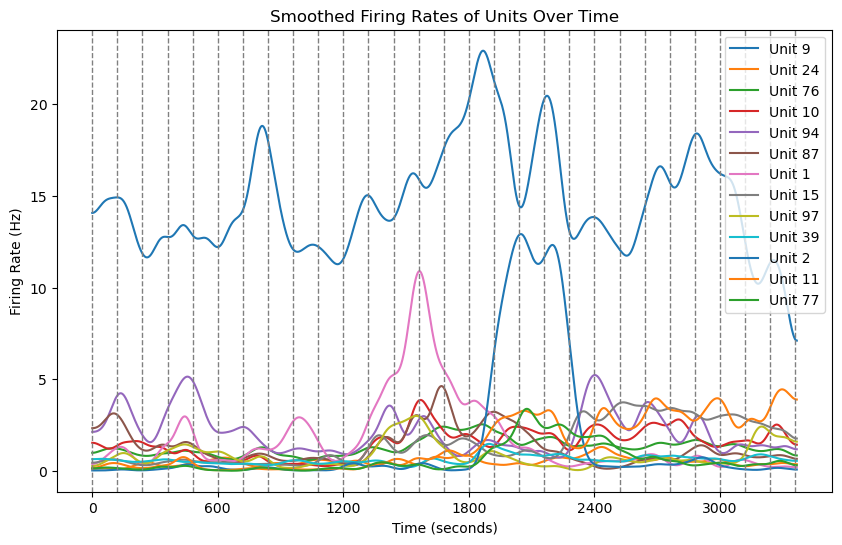

In [98]:
plt.figure(figsize=(10, 6))

# Plotting each unit's firing rate
for unit, rates in recording1.unit_firing_rates.items():
    smoothed_rates = gaussian_filter(rates, sigma=400)  # Adjust sigma for desired smoothness
    plt.plot(smoothed_rates, label=f'Unit {unit}')

# Determine the total bins from the length of any firing rate data
total_bins = len(next(iter(recording1.unit_firing_rates.values())))

# Adjust the x-axis to display time in seconds
# Here, every bin is 100 ms, so every 6000 bins are 600 seconds (10 minutes)
plt.xticks(np.arange(0, total_bins, 6000), labels=[f"{int(x/10)}" for x in np.arange(0, total_bins, 6000)])  # Update labels every 600 seconds

# Adding vertical dashed lines every 60 seconds
# Since each bin is 100 ms, 60 seconds would be every 600 bins
sixty_second_intervals = np.arange(0, total_bins, 1200)
for idx in sixty_second_intervals:
    plt.axvline(x=idx, color='gray', linestyle='--', linewidth=1)

plt.xlabel('Time (seconds)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Smoothed Firing Rates of Units Over Time')
plt.legend()
plt.show()

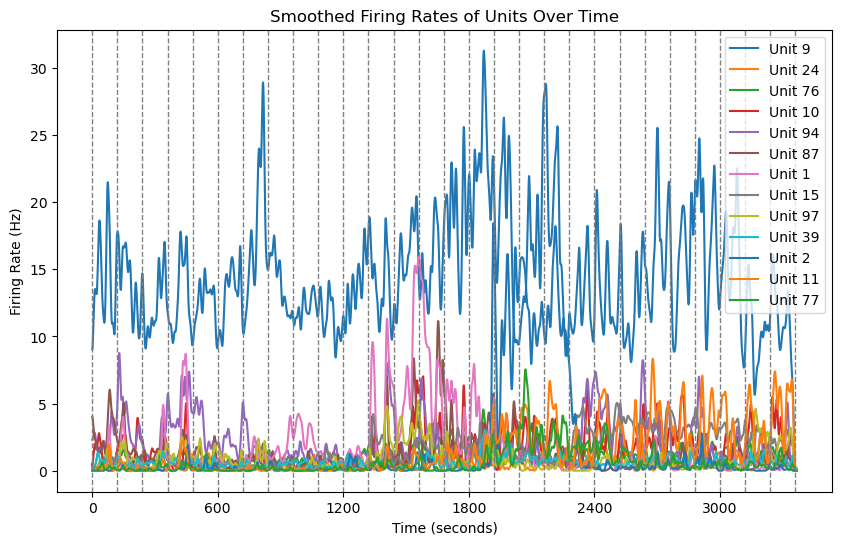

In [100]:
plt.figure(figsize=(10, 6))

# Plotting each unit's firing rate
for unit, rates in recording1.unit_firing_rates.items():
    smoothed_rates = gaussian_filter(rates, sigma=50)  # Adjust sigma for desired smoothness
    plt.plot(smoothed_rates, label=f'Unit {unit}')

# Determine the total bins from the length of any firing rate data
total_bins = len(next(iter(recording1.unit_firing_rates.values())))

# Adjust the x-axis to display time in seconds
# Here, every bin is 100 ms, so every 6000 bins are 600 seconds (10 minutes)
plt.xticks(np.arange(0, total_bins, 6000), labels=[f"{int(x/10)}" for x in np.arange(0, total_bins, 6000)])  # Update labels every 600 seconds

# Adding vertical dashed lines every 60 seconds
# Since each bin is 100 ms, 60 seconds would be every 600 bins
sixty_second_intervals = np.arange(0, total_bins, 1200)
for idx in sixty_second_intervals:
    plt.axvline(x=idx, color='gray', linestyle='--', linewidth=1)

plt.xlabel('Time (seconds)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Smoothed Firing Rates of Units Over Time')
plt.legend()
plt.show()

In [101]:
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin=5, smoothing_window=250, ignore_freq=0.5)

All set to analyze


In [102]:
recordings = spike_analysis.ephyscollection.collection
recording_name = '20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-1_t1b3L_box1_merged.rec'
recording1 = recordings.get(recording_name)

len(recording1.unit_spiketrains[9])

673476

C:\Users\short\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


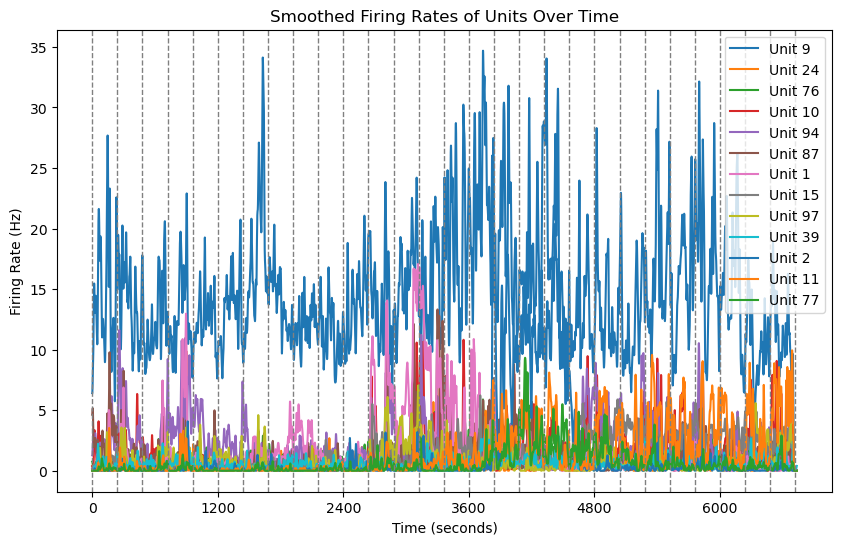

In [104]:
plt.figure(figsize=(10, 6))

# Plotting each unit's firing rate
for unit, rates in recording1.unit_firing_rates.items():
    smoothed_rates = gaussian_filter(rates, sigma=400)  # Adjust sigma for desired smoothness
    plt.plot(smoothed_rates, label=f'Unit {unit}')

# Determine the total bins from the length of any firing rate data
total_bins = len(next(iter(recording1.unit_firing_rates.values())))

# Adjust the x-axis to display time in seconds
# Here, every bin is 100 ms, so every 6000 bins are 600 seconds (10 minutes)
plt.xticks(np.arange(0, total_bins, 120000), labels=[f"{int(x/100)}" for x in np.arange(0, total_bins, 120000)])  # Update labels every 600 seconds

# Adding vertical dashed lines every 60 seconds
# Since each bin is 100 ms, 60 seconds would be every 600 bins
sixty_second_intervals = np.arange(0, total_bins, 24000)
for idx in sixty_second_intervals:
    plt.axvline(x=idx, color='gray', linestyle='--', linewidth=1)

plt.xlabel('Time (seconds)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Smoothed Firing Rates of Units Over Time')
plt.legend()
plt.show()

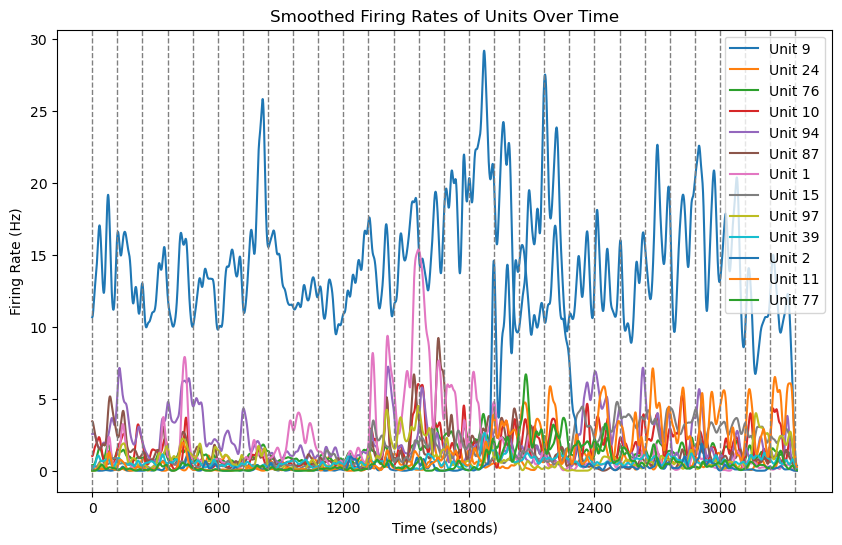

In [110]:
plt.figure(figsize=(10, 6))

# Plotting each unit's firing rate
for unit, rates in list(recording1.unit_firing_rates.items()):  # Limiting the number of units to reduce clutter
    smoothed_rates = gaussian_filter(rates, sigma=1600)  # Adjust sigma for desired smoothness
    plt.plot(smoothed_rates, label=f'Unit {unit}')

# Determine the total bins from the length of any firing rate data
total_bins = len(next(iter(recording1.unit_firing_rates.values())))

# Calculate the appropriate scaling factor from bins to seconds (5 ms per bin, so 200 bins per second)
seconds_per_tick = 600  # We want a tick every 600 seconds
bins_per_tick = seconds_per_tick * 200  # Convert seconds to bins

# Generate tick positions and labels
tick_positions = np.arange(0, total_bins, bins_per_tick)
tick_labels = [f"{int(tick / 200)}" for tick in tick_positions]  # Convert bin position back to seconds for labeling

plt.xticks(tick_positions, labels=tick_labels)  # Set the ticks and labels

# Add vertical dashed lines every 60 seconds
sixty_second_intervals = np.arange(0, total_bins, 24000)  # 12000 bins are 60 seconds
for idx in sixty_second_intervals:
    plt.axvline(x=idx, color='gray', linestyle='--', linewidth=1)

plt.xlabel('Time (seconds)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Smoothed Firing Rates of Units Over Time')
plt.legend(loc='upper right')  # Position legend to not slow down plotting
plt.show()

In [112]:
spike_analysis = spike.SpikeAnalysis_MultiRecording(ephys_data, timebin = 100, smoothing_window=250, ignore_freq = 0.5)

All set to analyze


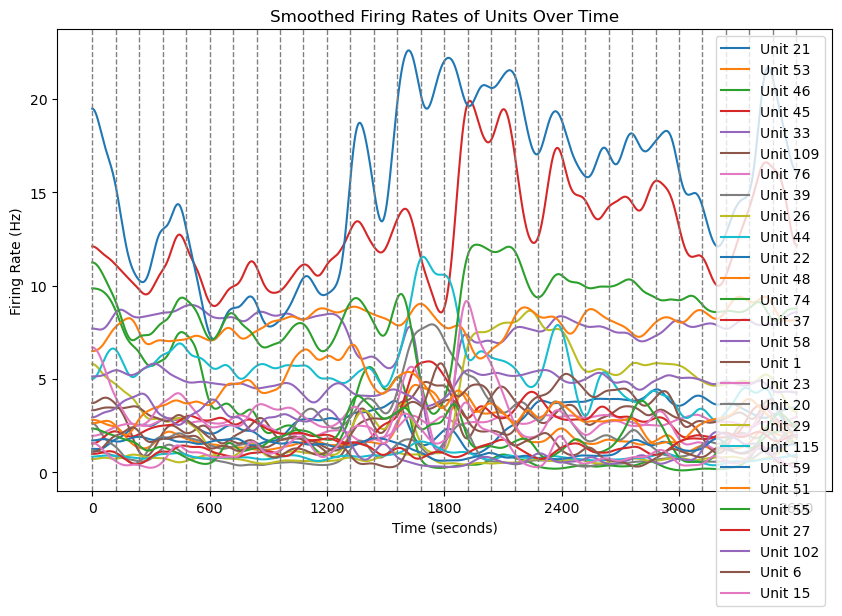

In [114]:
recordings = spike_analysis.ephyscollection.collection
recording_name = '20230622_110832_standard_comp_to_both_rewarded_D1_subj_1-2_t3b3L_box1_merged.rec'
recording2 = recordings.get(recording_name)

plt.figure(figsize=(10, 6))

# Plotting each unit's firing rate
for unit, rates in recording2.unit_firing_rates.items():
    smoothed_rates = gaussian_filter(rates, sigma=400)  # Adjust sigma for desired smoothness
    plt.plot(smoothed_rates, label=f'Unit {unit}')

# Determine the total bins from the length of any firing rate data
total_bins = len(next(iter(recording2.unit_firing_rates.values())))

# Adjust the x-axis to display time in seconds
# Here, every bin is 100 ms, so every 6000 bins are 600 seconds (10 minutes)
plt.xticks(np.arange(0, total_bins, 6000), labels=[f"{int(x/10)}" for x in np.arange(0, total_bins, 6000)])  # Update labels every 600 seconds

# Adding vertical dashed lines every 60 seconds
# Since each bin is 100 ms, 60 seconds would be every 600 bins
sixty_second_intervals = np.arange(0, total_bins, 1200)
for idx in sixty_second_intervals:
    plt.axvline(x=idx, color='gray', linestyle='--', linewidth=1)

plt.xlabel('Time (seconds)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Smoothed Firing Rates of Units Over Time')
plt.legend()
plt.show()

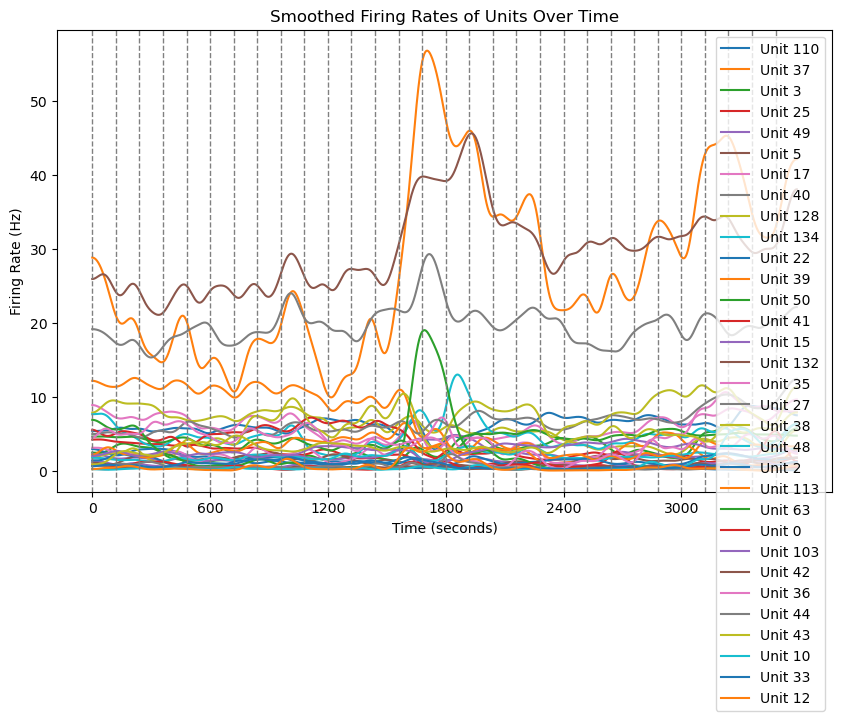

In [115]:
recording_name = '20230624_105855_standard_comp_to_both_rewarded_D3_subj_1-2_t1b2L_box1_merged.rec'
recording3 = recordings.get(recording_name)

plt.figure(figsize=(10, 6))

# Plotting each unit's firing rate
for unit, rates in recording3.unit_firing_rates.items():
    smoothed_rates = gaussian_filter(rates, sigma=400)  # Adjust sigma for desired smoothness
    plt.plot(smoothed_rates, label=f'Unit {unit}')

# Determine the total bins from the length of any firing rate data
total_bins = len(next(iter(recording3.unit_firing_rates.values())))

# Adjust the x-axis to display time in seconds
# Here, every bin is 100 ms, so every 6000 bins are 600 seconds (10 minutes)
plt.xticks(np.arange(0, total_bins, 6000), labels=[f"{int(x/10)}" for x in np.arange(0, total_bins, 6000)])  # Update labels every 600 seconds

# Adding vertical dashed lines every 60 seconds
# Since each bin is 100 ms, 60 seconds would be every 600 bins
sixty_second_intervals = np.arange(0, total_bins, 1200)
for idx in sixty_second_intervals:
    plt.axvline(x=idx, color='gray', linestyle='--', linewidth=1)

plt.xlabel('Time (seconds)')
plt.ylabel('Firing Rate (Hz)')
plt.title('Smoothed Firing Rates of Units Over Time')
plt.legend()
plt.show()